# RACE PACE ANALYSIS 

In [1]:
import fastf1
import fastf1.plotting 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

In [4]:
# 1. SETUP: Enable cache and styling
# Pointing to the 'data' folder we created in the root
fastf1.Cache.enable_cache(os.path.join("..", "data"))
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)


# 2. DATA EXTRACTION: Target FP2 (Race Simulation Session)
session = fastf1.get_session(2025, 'Abu Dhabi', 'FP2')
session.load()

# 3. CLEANING: Get all laps and filter for "Clean Air" pace
# pick_quicklaps() removes laps > 107% of the fastest lap
# pick_wo_box() removes laps where the driver entered or exited the pits
laps= session.laps.pick_quicklaps().pick_wo_box()

#Convert LapTime (timedelta) to seconds for the plot
laps['LapTime(s)']=laps['LapTime'].dt.total_seconds()

# 4. PREPARE THE DATA: Get top 10 finishers or specific drivers
drivers = session.results['Abbreviation'].head(10).tolist()
plot_laps = laps[laps['Driver'].isin(drivers)]



c:\Users\trive\AppData\Local\Programs\Python\Python312\Lib\site-packages\fastf1\plotting\_plotting.py:57: FutureWarning: The `misc_mpl_mods` argument was dropped from `.setup_mpl()` in version 3.6.0 and has no effect anymore. It will be removed in a future version of FastF1.
  warnings.warn(
core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 2 [v3.7.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_ap

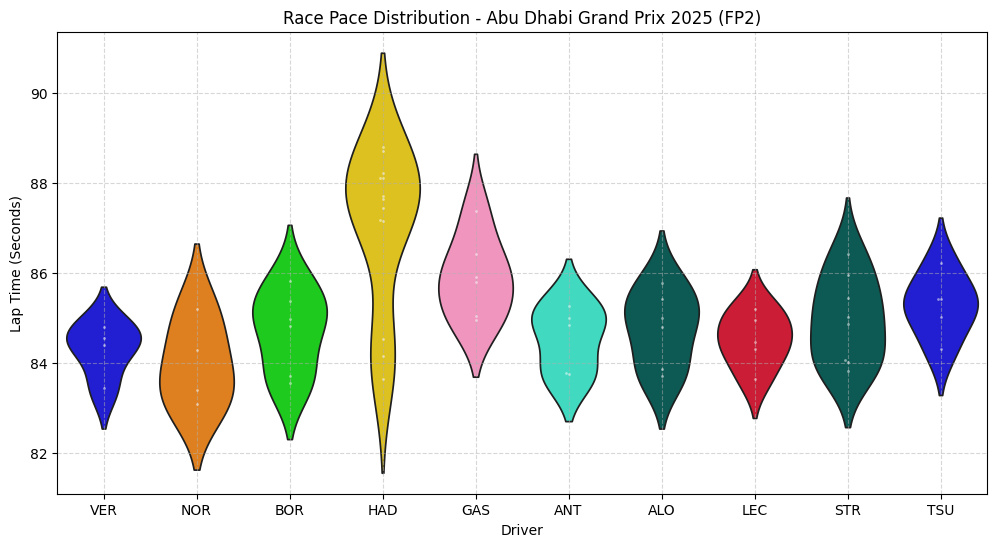

Analysis complete. Plot saved to: ..\output\race_pace_violin.png


In [8]:

# 5. VISUALIZATION: Create the Violin Plot
plt.figure(figsize=(12, 6))

# Use the driver-to-color mapping for accuracy
driver_colors = fastf1.plotting.get_driver_color_mapping(session=session)

sns.violinplot(
    data=plot_laps, 
    x='Driver', 
    y='LapTime(s)', 
    inner=None, 
    palette=driver_colors,
    hue='Driver',
    legend=False
)

# Overlay a swarm plot to see individual lap points
sns.swarmplot(data=plot_laps, x='Driver', y='LapTime(s)', color='white', size=2, alpha=0.5)

plt.title(f"Race Pace Distribution - {session.event.EventName} 2025 (FP2)")
plt.ylabel("Lap Time (Seconds)")
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Save the output to our 'outputs' folder
output_path = os.path.join('..', 'output', 'race_pace_violin.png')
plt.savefig(output_path)
plt.show()

print(f"Analysis complete. Plot saved to: {output_path}")


**SUMMARY:Lap Time vs. Driver**
&nbsp;&nbsp;&nbsp;&nbsp;This provides the model with a "Power Ranking" of who has the fastest car in race-trim.

-  **width** : concentration of laps; 
a wider section means many laps were completed at or around that time.

-**Pace:** A violin positioned lower (faster times) indicates better pace.


**CONTRIBUTION TO THE PRED MODEL**


Feature: "Performance Stability." The model uses the variance (height of the violin) to calculate the probability of a driver making a mistake or falling into a "DRS train" during the race.

In [13]:
from ipywidgets import interact, SelectMultiple


# 1. Get a list of all unique drivers from the session results
all_drivers = sorted(session.results['Abbreviation'].unique())

# 2. Create the interactive function
def plot_multi_driver_consistency(selected_drivers):
    if not selected_drivers:
        print("Please select at least one driver from the list.")
        return

    # Filter data for selected drivers
    comparison_laps = laps[laps['Driver'].isin(selected_drivers)].copy()
    
    plt.figure(figsize=(14, 7))
    
    # Get official colors
    driver_colors = fastf1.plotting.get_driver_color_mapping(session=session)
    
    # Plotting: X is the Stint, Y is the LapTime, Hue is the Driver
    sns.violinplot(
        data=comparison_laps, 
        x='Stint', 
        y='LapTime(s)', 
        hue='Driver',
        palette=driver_colors,
        inner="quartile",
        gap=.1 # Adds a small gap between the violins for better visibility
    )

    plt.title(f"Pace Comparison per Stint: {', '.join(selected_drivers)}")
    plt.ylabel("Lap Time (Seconds)")
    plt.xlabel("Stint Number")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 3. Display the Selection Box
# Hold 'Ctrl' (Windows) or 'Cmd' (Mac) to select multiple drivers at once
print("Hold Ctrl/Cmd to select multiple drivers:")
interact(plot_multi_driver_consistency, selected_drivers=SelectMultiple(options=all_drivers, value=['VER', 'HAM']))

Hold Ctrl/Cmd to select multiple drivers:


interactive(children=(SelectMultiple(description='selected_drivers', index=(19, 8), options=('ALB', 'ALO', 'AN…

<function __main__.plot_multi_driver_consistency(selected_drivers)>

**SUMMARY . Stint-Wise Evolution Plot (Lap Time vs. Stint)**
&nbsp;It answers: "How much slower did the driver get as the tires got older?
- **Vertical Shift:** If Stint 2’s violin is higher up the Y-axis than Stint 1, it visually confirms the "slow down" caused by tire wear.

- **"Skinny" Violin:** If a stint has a very thin, long violin, it means the driver had "dirty air" or high degradation.

- **"Fat" Violin:** If it's wide and short, the driver was in a perfect, consistent rhythm.